table of contents  
1. Prepare  
2. Import Dataset and Preprocess
3. Compute Stretch Index

# Prepare

## Import Library

In [1]:
import os, time, sys
from datetime import datetime, date
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')
%matplotlib inline

# import Metrica Utilities
sys.path.append(os.path.join('..','src'))
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

## Setting static parameter

In [2]:
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, '..', 'sample-data', 'data')

# Read Dataset, and Preprocess

In [3]:
# Read Daset
game_id = 2
events_df = mio.read_event_data(data_dir, game_id)
tracking_home_df = mio.tracking_data(data_dir, game_id, 'Home')
tracking_away_df = mio.tracking_data(data_dir, game_id, 'Away')

# convert positions
events_df = mio.to_metric_coordinates(events_df)
tracking_home_df = mio.to_metric_coordinates(tracking_home_df)
tracking_away_df = mio.to_metric_coordinates(tracking_away_df)

# rebase direction
tracking_home_df, tracking_away_df, events_df = mio.to_single_playing_direction(tracking_home_df, tracking_away_df, events_df)
"""
if game_id == 1:
    columns = [c for c in tracking_away_df.columns if c[-1].lower() in ['x','y']]
    tracking_away_df.loc[:,columns] *= -1
else:
    columns = [c for c in tracking_home_df.columns if c[-1].lower() in ['x','y']]
    tracking_home_df.loc[:,columns] *= -1
"""

# dataset_dict[f'game_id={game_id}'] = [tracking_home_df, tracking_away_df, events_df]

# calculate player Velocities
# tracking_home_df = mvel.calc_player_velocities(tracking_home_df, smoothing=True, filter_='moving average')
# tracking_away_df = mvel.calc_player_velocities(tracking_away_df, smoothing=True, filter_='moving average')

Reading team: home
Reading team: away


"\nif game_id == 1:\n    columns = [c for c in tracking_away_df.columns if c[-1].lower() in ['x','y']]\n    tracking_away_df.loc[:,columns] *= -1\nelse:\n    columns = [c for c in tracking_home_df.columns if c[-1].lower() in ['x','y']]\n    tracking_home_df.loc[:,columns] *= -1\n"

# Possession, Non Possession

In [4]:
c_list = ['Period', 'Team', 'Start Time [s]', 'End Time [s]']
posession_list = []
for period in events_df.Period.unique():
    events_df_tmp = events_df[events_df.Period==period]
    
    team, st, ed = events_df_tmp.groupby('Period').agg({'Team':'first', 'Start Time [s]':'first', 'End Time [s]':'last'}).values[0,:]
    
    flg_array = events_df_tmp.Team.values[:-1] != events_df_tmp.Team.values[1:]
    events_df_only_transition = events_df_tmp[events_df_tmp.index.isin(events_df_tmp.index.values[1:][flg_array])]

    index_last = events_df_only_transition.index.values[-1]

    for i in events_df_only_transition.index:
        team_, st_ = events_df_only_transition.loc[i, c_list[1:-1]]

        if i == index_last:
            posession = [period, team_, st_, ed]
        else:
            posession  = [period, team, st, st_]

        # append
        posession_list.append(posession)

        # update
        team, st = team_, st_

# make df
possession_df = pd.DataFrame(data=posession_list, columns=c_list)

# Commpute Stretch Index

In [5]:
tracking_home_df.tail()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
141152,2,5646.08,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.8786,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09392,30.29672,23.36028,-9.04400,NaN,NaN
141153,2,5646.12,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.8786,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09286,30.34568,23.31046,-9.03176,NaN,NaN
141154,2,5646.16,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.8786,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09074,30.40348,23.28714,-9.02632,NaN,NaN
141155,2,5646.20,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.8786,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.08968,30.45856,23.25746,-9.03992,NaN,NaN
141156,2,5646.24,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.8786,24.22948,-12.09788,...,NaN,NaN,9.71278,-24.17468,-1.09074,30.49528,23.25110,-9.18612,NaN,NaN


In [6]:
n_player = 10

def replace_value_to_nan(data_array, index_array):
    for i, d in enumerate(index_array.sum(axis=1)):
        if d!=2*n_player:
            data_array[i, np.nonzero(np.isnan(data_array[i+1]))] = np.nan

    return data_array[0]

def compute_stretch_index(tracking_df):
    stretch_index_list = []
    for i in tqdm(tracking_df.index[:]):
        tracking_array = tracking_df[tracking_df.index==i].iloc[:,4:-2].values.reshape(-1)
        index_array = ~np.isnan(tracking_array)
        if len(tracking_array[index_array]) % (n_player*2) == 0:
            tracking_array = tracking_array[index_array].reshape(n_player,2)
        else:
            tracking_array = tracking_df[(i<=tracking_df.index)&(tracking_df.index<i+10)].iloc[:,4:-2].values
            index_array = ~np.isnan(tracking_array)
            tracking_array = replace_value_to_nan(tracking_array, index_array)
            tracking_array = tracking_array[~np.isnan(tracking_array)].reshape(n_player,2)

        stretch_index = np.mean(np.linalg.norm(tracking_array - tracking_array.mean(axis=0), axis=1))
        stretch_index_list.append(stretch_index)

    tracking_df['stretch_index'] = stretch_index_list


    return tracking_df

In [38]:
twitter_color = "#141d26"

def set_tone(ax):
    # remove axis labels and ticks
    ax.spines['left'].set_color('w'); ax.tick_params(axis='y', colors='w'); ax.xaxis.label.set_color('w')
    ax.spines['bottom'].set_color('w'); ax.tick_params(axis='x', colors='w'); ax.yaxis.label.set_color('w')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_facecolor(twitter_color)

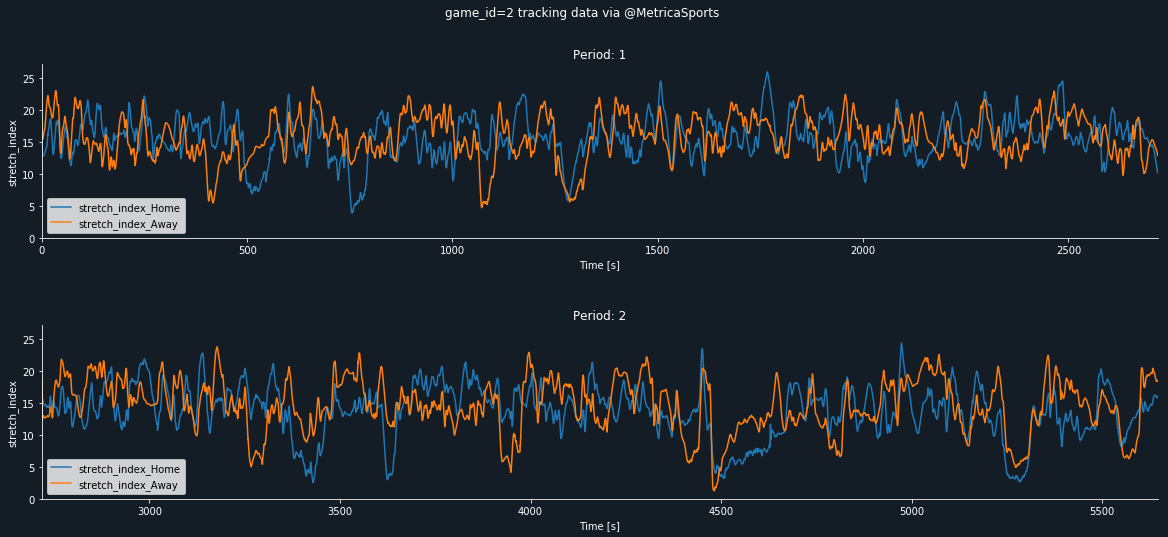

In [44]:
c_key = 'Time [s]'; c_value = 'stretch_index'

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 4*2), sharey=True)
plt.subplots_adjust(hspace=0.5)
for period in range(1,3):
    ax = axes[period-1]
    set_tone(ax)
    tracking_home_df[tracking_home_df.Period==period][[c_key, c_value]].plot(x=c_key, y=c_value, ax=ax, label=f'{c_value}_Home')
    tracking_away_df[tracking_away_df.Period==period][[c_key, c_value]].plot(x=c_key, y=c_value, ax=ax, label=f'{c_value}_Away')

    ax.set_xlabel(c_key, color='w'); ax.set_ylabel(c_value, color='w'); ax.set_title(f'Period: {period}', color='w')

fig.patch.set_facecolor(twitter_color)
fig.suptitle(f'game_id={game_id} tracking data via @MetricaSports', color='w')
plt.savefig(os.path.join('..','reports','figure',f'game_id={game_id}_stretch_index.png'), bbox_inches='tight', facecolor=twitter_color)

## 詳細分析

### ボールの位置

In [141]:
xmin, xmax = -56, 56
ymin, ymax = -37, 37

x_bins = np.linspace(xmin, xmax, 3*2+1)
y_bins = np.linspace(ymin, ymax, 5+1)

In [164]:
import matplotlib.patches as patches
import matplotlib.colorbar as cbar

alpha = 0.8

cmap = plt.cm.RdYlBu_r

def plot_stretch_index(stretch_index_summary, attacking_direction):
    fig, ax = mviz.plot_pitch(field_color='twitter_dark_mode')
    normal = plt.Normalize(stretch_index_summary.stretch_index.min(),stretch_index_summary.stretch_index.max()) # my numbers from 0-1
    colormap = cmap(normal(stretch_index_summary.stretch_index.values))

    c_list = ['ball_x', 'ball_y']
    for c in c_list:
        stretch_index_summary[f'{c}_left'] = stretch_index_summary[c].apply(lambda x: x.left)
        stretch_index_summary[f'{c}_right'] = stretch_index_summary[c].apply(lambda x: x.right)

    for i in stretch_index_summary.index:
        stretch_index, x_left, x_right, y_left, y_right = stretch_index_summary.iloc[i, 2:].values
        if x_left < 0 and y_left < 0:
            rect = patches.Rectangle((x_left,y_left), width=-x_left-x_right, height=-y_left-y_right, facecolor=colormap[i], alpha=alpha)
        elif x_left < 0 and y_left >= 0:
            rect = patches.Rectangle((x_left,y_left), width=-x_left-x_right, height=y_right-y_left, facecolor=colormap[i], alpha=alpha)
        elif x_left >= 0 and y_left < 0:
            rect = patches.Rectangle((x_left,y_left), width=x_right-x_left, height=-y_left-y_right, facecolor=colormap[i], alpha=alpha)
        else:
            rect = patches.Rectangle((x_left,y_left), width=x_right-x_left, height=y_right-y_left, facecolor=colormap[i], alpha=alpha)
        ax.add_patch(rect)

    cax, _ = cbar.make_axes(ax) 
    cb = cbar.ColorbarBase(cax, cmap=cmap, norm=normal)

    cb.ax.yaxis.set_tick_params(color='w')

    # set colorbar edgecolor 
    cb.outline.set_edgecolor(None)

    cb.set_label('stretch index', color='w')

    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='w')

    ax.spines['top'].set_visible(False); ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False); ax.spines['right'].set_visible(False)

    if attacking_direction:
        ax.text(0, -28, 'attacking', va='bottom', ha='center', fontsize=18, color='w')

    if attacking_direction == 'right':
        ax.arrow(x=-10,y=-30,dx=20,dy=0,head_width=2,head_length=2,length_includes_head=True,color='w')
    elif attacking_direction == 'left':
        ax.arrow(x=10,y=-30,dx=-20,dy=0,head_width=2,head_length=2,length_includes_head=True,color='w')

    return fig, ax

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2ed64a90>)

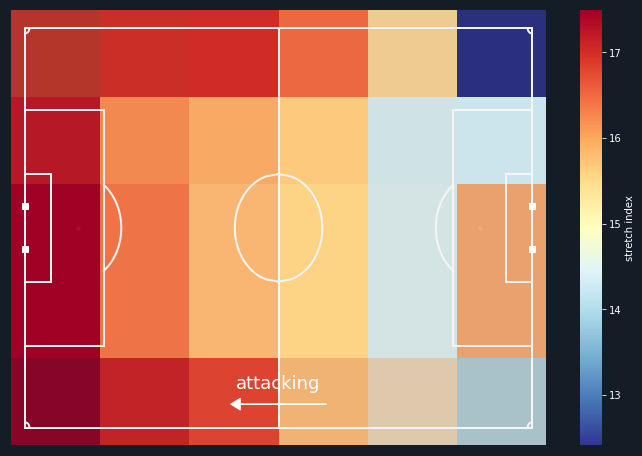

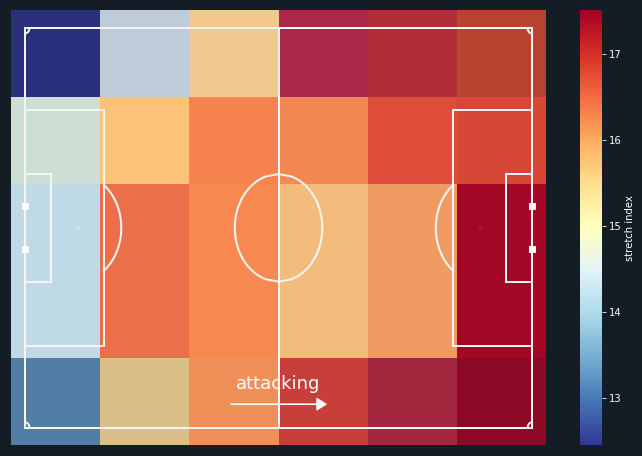

In [165]:
plot_stretch_index(tracking_home_df.groupby([pd.cut(tracking_home_df.ball_x, x_bins), pd.cut(tracking_home_df.ball_y, y_bins)]).stretch_index.mean().reset_index(), 'left')

plot_stretch_index(tracking_away_df.groupby([pd.cut(tracking_away_df.ball_x, x_bins), pd.cut(tracking_away_df.ball_y, y_bins)]).stretch_index.mean().reset_index(), 'right')

In [7]:
tracking_home_df = compute_stretch_index(tracking_home_df)
tracking_away_df = compute_stretch_index(tracking_away_df)

100%|██████████| 141156/141156 [03:07<00:00, 750.85it/s]
